<a href="https://colab.research.google.com/github/tajerian/diabetes_Dx_ML/blob/main/diabetesipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import pandas
import pandas as pd

# Import numpy
import numpy as np

# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Import cross_val_score
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report

# Silence warnings
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

In [2]:
# First go to your Kaggle account and create New API Token, a kaggle.json file will be download.

# Make sure you have a kaggle.json file.
!ls -lha kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

# You can use copy API command from kaggle to be sure
!kaggle datasets download -d uciml/pima-indians-diabetes-database

# Unzip data in Google Colab
!unzip -q /content/pima-indians-diabetes-database.zip

-rw-r--r-- 1 root root 68 Dec 16 19:14 kaggle.json
kaggle.json
  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 6.41MB/s]


In [3]:
df=pd.read_csv('/content/diabetes.csv')
df
x=df.iloc[:,0:-1]
y=df.iloc[:,-1]

In [4]:
df.isna().sum().sum()

0

In [5]:
df.info()
var=[i for i in df]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=.7, random_state=1)

In [7]:
#feature scaling
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(copy=True)
scaler.fit(X_train)
x_train= scaler.transform(X_train)
x_test=scaler.transform(X_test)

In [8]:
train=pd.Series.to_frame(y_train)
train.rename(columns = {'Outcome':'train_label'}, inplace = True)
test=pd.Series.to_frame(y_test)
test.rename(columns = {'Outcome':'test_label'}, inplace = True)

In [9]:
from sklearn.model_selection import cross_val_score

# Define cross_val function with classifer and num_splits as input
def cross_val(classifier, X, y, num_splits=10):
    
    # Initialize classifier
    model = classifier

    # Obtain scores of cross-validation
    scores = cross_val_score(model, X, y, cv=num_splits)

    # Display accuracy
    print('Accuracy:', np.round(scores, 2))

    # Display mean accuracy
    print('Accuracy mean: %0.2f' % (scores.mean()))


In [10]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [11]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_proba = model.predict_proba(x_test)
accuracy_score(y_test, y_proba.argmax(axis=1))
cross_val(model, x, y)

Accuracy: [0.74 0.78 0.81 0.71 0.74 0.77 0.82 0.81 0.76 0.83]
Accuracy mean: 0.78


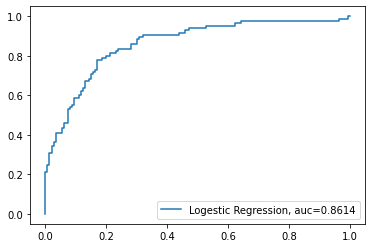

In [12]:
fpr, tpr, _ = roc_curve(y_test,  y_proba[:,1])
auc = roc_auc_score(y_test,  y_proba[:,1])
plt.plot(fpr,tpr,label="Logestic Regression, auc="+ "%.4f" % auc)
plt.legend(loc=4)
plt.show()

In [13]:
test['Log_Reg']=model.predict_proba(x_test)[:,1]
train['Log_Reg']=model.predict_proba(x_train)[:,1]

In [14]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=100, max_depth=2)
model.fit(x_train, y_train)
y_proba = model.predict_proba(x_test)
accuracy_score(y_test, y_proba.argmax(axis=1))

0.7965367965367965

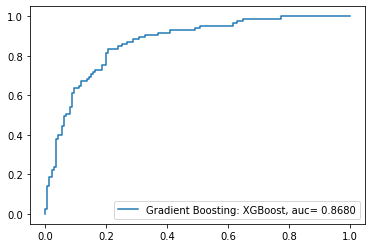

In [15]:
fpr, tpr, _ = roc_curve(y_test,  y_proba[:,1])
auc = roc_auc_score(y_test,  y_proba[:,1])
plt.plot(fpr,tpr,label="Gradient Boosting: XGBoost, auc= "+ "%.4f" % auc)
plt.legend(loc=4)
plt.show()

In [16]:
test['XGBoost']=model.predict_proba(x_test)[:,1]
train['XGBoost']=model.predict_proba(x_train)[:,1]

In [17]:
cross_val(model, x, y)

Accuracy: [0.75 0.82 0.78 0.66 0.74 0.81 0.81 0.83 0.68 0.79]
Accuracy mean: 0.77


In [18]:
# Import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV
from sklearn.tree import DecisionTreeClassifier

def randomized_search_clf(params, runs=20, clf=DecisionTreeClassifier(random_state=2)):

    # Instantiate GridSearchCV as grid_reg
    rand_clf = RandomizedSearchCV(clf, params, n_iter=runs, 
                                  cv=5, n_jobs=-1, random_state=2)
    
    # Fit grid_reg on X_train and y_train
    rand_clf.fit(X_train, y_train)

    # Extract best estimator
    best_model = rand_clf.best_estimator_
    
    # Extract best score
    best_score = rand_clf.best_score_

    # Print best score
    print("Training score: {:.3f}".format(best_score))

    # Predict test set labels
    y_pred = best_model.predict(X_test)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print accuracy
    print('Test score: {:.3f}'.format(accuracy))
        
    # Return best model
    return best_model


In [19]:
randomized_search_clf(params={'criterion':['entropy', 'gini'],
                              'splitter':['random', 'best'],
                          'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01],
                          'min_samples_split':[2, 3, 4, 5, 6, 8, 10],
                          'min_samples_leaf':[1, 0.01, 0.02, 0.03, 0.04],
                          'min_impurity_decrease':[0.0, 0.0005, 0.005, 0.05, 0.10, 0.15, 0.2],
                          'max_leaf_nodes':[10, 15, 20, 25, 30, 35, 40, 45, 50, None],
                          'max_features':['auto', 0.95, 0.90, 0.85, 0.80, 0.75, 0.70],
                          'max_depth':[None, 2,4,6,8],
                          'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05]
                         })

Training score: 0.760
Test score: 0.784


DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features=0.8,
                       max_leaf_nodes=45, min_samples_leaf=0.04,
                       min_samples_split=10, min_weight_fraction_leaf=0.05,
                       random_state=2)

In [20]:
# Initialize classification model
model = DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features=0.8,
                       max_leaf_nodes=45, min_samples_leaf=0.04,
                       min_samples_split=10, min_weight_fraction_leaf=0.05,
                       random_state=2)

model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)
accuracy_score(y_test, y_proba.argmax(axis=1))

0.7835497835497836

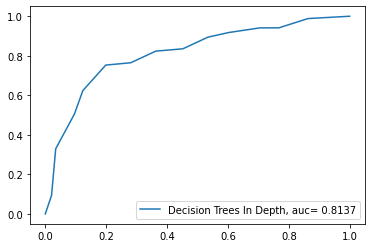

In [21]:
fpr, tpr, _ = roc_curve(y_test,  y_proba[:,1])
auc = roc_auc_score(y_test,  y_proba[:,1])
plt.plot(fpr,tpr,label="Decision Trees In Depth, auc= "+ "%.4f" % auc)
plt.legend(loc=4)
plt.show()

In [22]:
test['Decision Trees']=model.predict_proba(X_test)[:,1]
train['Decision Trees']=model.predict_proba(X_train)[:,1]

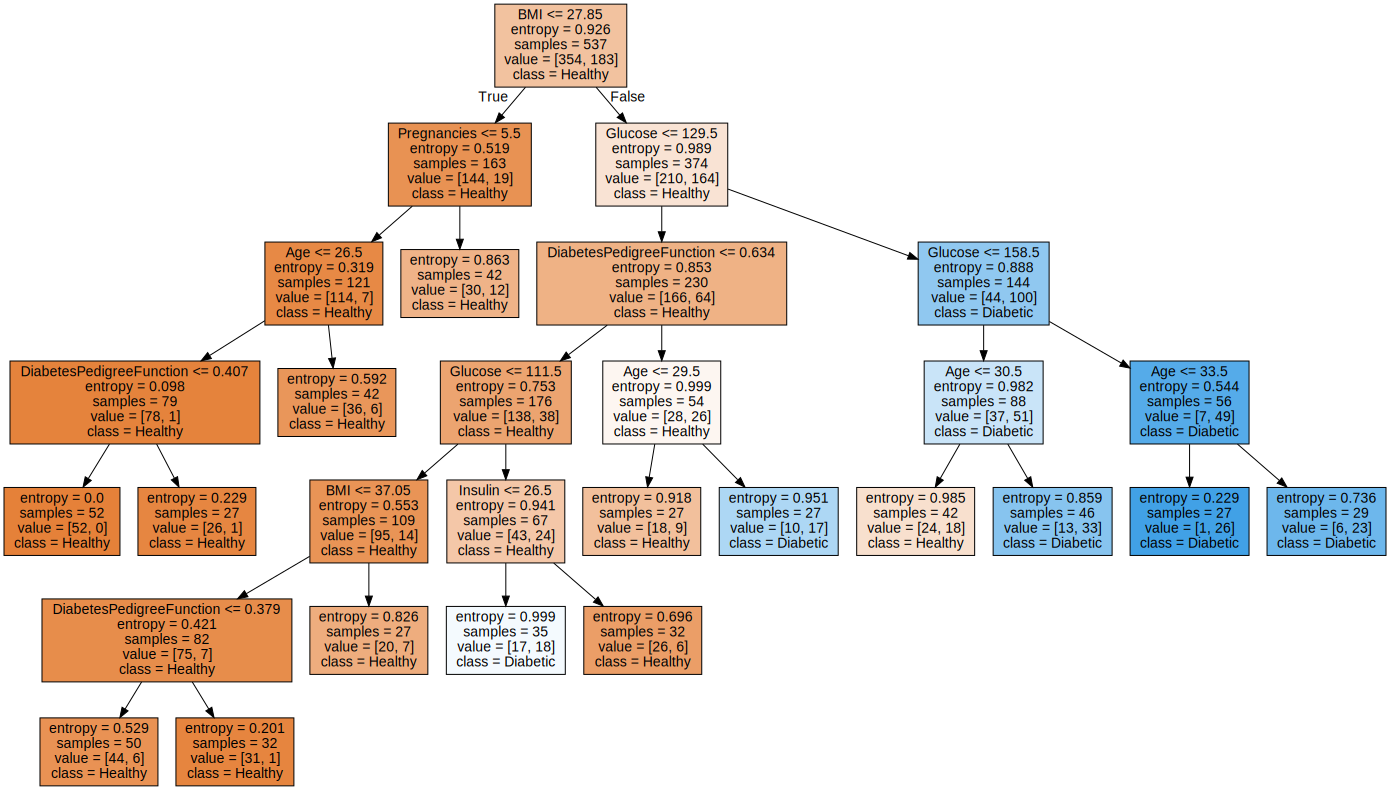

In [23]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=var[0:-1],  
                                class_names=['Healthy', 'Diabetic'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph.render("decision_tree_graphivz")
graph


In [24]:
!pip install dtreeviz
!apt-get install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 643 kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


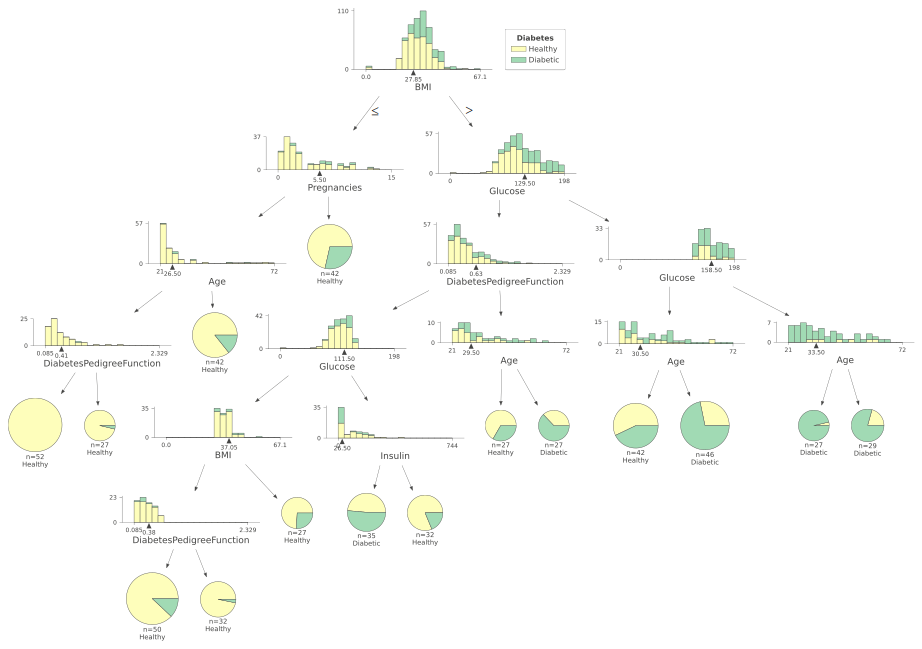

In [25]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(model, X_train, y_train,
                target_name="Diabetes",
                feature_names=var[0:-1],
                class_names=['Healthy', 'Diabetic'])
viz.save("decision_tree_viz.svg")
viz

In [26]:
cross_val(model, x, y)

Accuracy: [0.69 0.74 0.69 0.66 0.66 0.79 0.78 0.82 0.75 0.78]
Accuracy mean: 0.74


In [27]:
from sklearn.ensemble import RandomForestClassifier

model= RandomForestClassifier(oob_score=True, n_estimators=100, random_state=2, n_jobs=-1)
model.fit(x_train, y_train)
y_proba = model.predict_proba(x_test)
accuracy_score(y_test, y_proba.argmax(axis=1))

0.7878787878787878

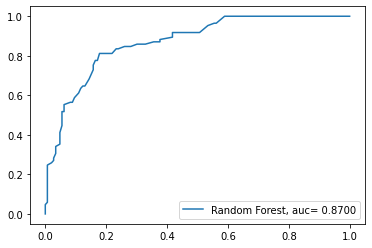

In [28]:
fpr, tpr, _ = roc_curve(y_test,  y_proba[:,1])
auc = roc_auc_score(y_test,  y_proba[:,1])
plt.plot(fpr,tpr,label="Random Forest, auc= "+ "%.4f" % auc)
plt.legend(loc=4)
plt.show()

In [29]:
test['Random Forest']=model.predict_proba(x_test)[:,1]
train['Random Forest']=model.predict_proba(x_train)[:,1]

In [ ]:
import graphviz
import os
os.mkdir("/content/random_forest")
# DOT data
for i in range(len(model.estimators_)):
  dot_data = tree.export_graphviz(model.estimators_[i], out_file=None, 
                                  feature_names=var[0:-1],  
                                  class_names=['Healthy', 'Diabetic'],
                                 filled=True)

  # Draw graph
  graph = graphviz.Source(dot_data, format="png") 
  graph.render("/content/random_forest/decision_tree_random_forest"+f'{i+1}')
!zip RF.zip -r /content/random_forest

In [ ]:
cross_val(model, x, y)

Accuracy: [0.74 0.82 0.71 0.71 0.74 0.75 0.82 0.82 0.7  0.82]
Accuracy mean: 0.76


In [ ]:
from sklearn.naive_bayes import GaussianNB

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
model = GridSearchCV(estimator=GaussianNB(), 
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 

model.fit(x_train, y_train)
y_proba = model.predict_proba(x_test)
accuracy_score(y_test, y_proba.argmax(axis=1))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


0.7922077922077922

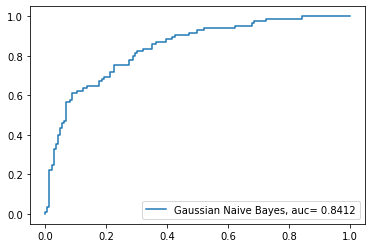

In [ ]:
fpr, tpr, _ = roc_curve(y_test,  y_proba[:,1])
auc = roc_auc_score(y_test,  y_proba[:,1])
plt.plot(fpr,tpr,label="Gaussian Naive Bayes, auc= "+ "%.4f" % auc)
plt.legend(loc=4)
plt.show()

In [ ]:
test['GaussianNB']=model.predict_proba(x_test)[:,1]
train['GaussianNB']=model.predict_proba(x_train)[:,1]

In [ ]:
cross_val(model, x, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Accuracy: [0.78 0.77 0.74 0.7  0.71 0.79 0.75 0.79 0.75 0.78]
Accuracy mean: 0.76


In [ ]:
from sklearn.svm import SVC 

params_SVC = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['sigmoid']}
model = GridSearchCV(estimator=SVC(probability=True), 
                 param_grid=params_SVC, 
                 cv=5,   # use any cross validation technique 
                 verbose=1, 
                 scoring='accuracy') 

model.fit(x_train, y_train)
y_proba = model.predict_proba(x_test)
accuracy_score(y_test, y_proba.argmax(axis=1))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


0.7922077922077922

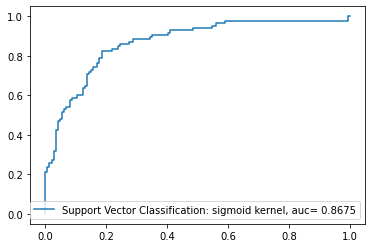

In [ ]:
fpr, tpr, _ = roc_curve(y_test,  y_proba[:,1])
auc = roc_auc_score(y_test,  y_proba[:,1])
plt.plot(fpr,tpr,label="Support Vector Classification: sigmoid kernel, auc= "+ "%.4f" % auc)
plt.legend(loc=4)
plt.show()

In [ ]:
test['SVC']=model.predict_proba(x_test)[:,1]
train['SVC']=model.predict_proba(x_train)[:,1]

Epoch 1/40
17/17 [==============================] - 2s 28ms/step - loss: 0.6677 - accuracy: 0.6574 - auc: 0.4700 - val_loss: 0.6744 - val_accuracy: 0.6320 - val_auc: 0.1761
Epoch 2/40
17/17 [==============================] - 0s 5ms/step - loss: 0.6504 - accuracy: 0.6592 - auc: 0.4375 - val_loss: 0.6544 - val_accuracy: 0.6320 - val_auc: 0.5892
Epoch 3/40
17/17 [==============================] - 0s 5ms/step - loss: 0.6308 - accuracy: 0.6574 - auc: 0.6312 - val_loss: 0.6336 - val_accuracy: 0.6364 - val_auc: 0.6645
Epoch 4/40
17/17 [==============================] - 0s 5ms/step - loss: 0.5978 - accuracy: 0.6946 - auc: 0.7031 - val_loss: 0.6023 - val_accuracy: 0.6667 - val_auc: 0.7220
Epoch 5/40
17/17 [==============================] - 0s 5ms/step - loss: 0.5720 - accuracy: 0.7020 - auc: 0.7313 - val_loss: 0.5815 - val_accuracy: 0.6883 - val_auc: 0.7516
Epoch 6/40
17/17 [==============================] - 0s 5ms/step - loss: 0.5555 - accuracy: 0.6965 - auc: 0.7475 - val_loss: 0.5512 - val_ac

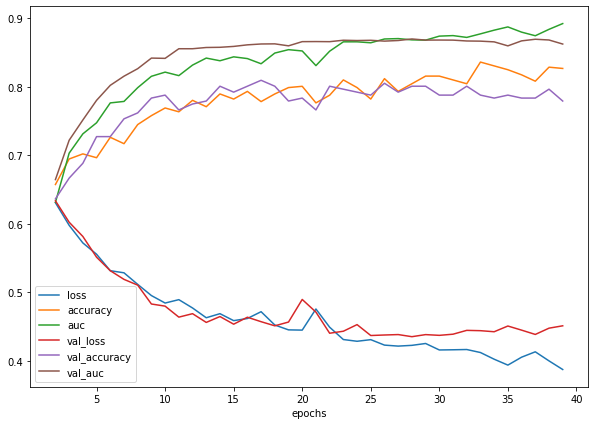

In [ ]:
import tensorflow as tf

model= tf.keras.Sequential([tf.keras.layers.Input(8,),
                            tf.keras.layers.Dense(64, activation='relu'),
                            tf.keras.layers.Dense(64, activation='relu'),
                            tf.keras.layers.Dense(64, activation='relu'),
                            tf.keras.layers.Dense(64, activation='relu'),
                            tf.keras.layers.Dense(64, activation='relu'),
                            tf.keras.layers.Dense(1, activation='sigmoid')])

# 2. Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), # binary since we are working with 2 clases (0 & 1)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy',tf.keras.metrics.AUC()])

# 3. Fit the model
hist=model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=40)
pd.DataFrame(hist.history)[2:].plot(figsize=(10,7), xlabel="epochs")

In [ ]:
os.mkdir('final1')
model.save('/content/final')
!zip model.zip -r /content/final1

  adding: content/final1/ (stored 0%)


In [ ]:
y_proba = model.predict(x_test)
print(model.evaluate(x_test, y_test,))
model.evaluate(x_train, y_train)

8/8 [==============================] - 0s 2ms/step - loss: 0.4510 - accuracy: 0.7792 - auc: 0.8624
[0.4510051906108856, 0.7792207598686218, 0.8624496459960938]
17/17 [==============================] - 0s 2ms/step - loss: 0.3711 - accuracy: 0.8492 - auc: 0.9055


[0.37112167477607727, 0.8491619825363159, 0.9054907560348511]

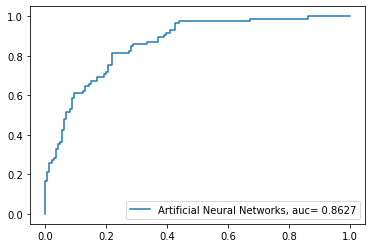

In [ ]:
fpr, tpr, _ = roc_curve(y_test,  y_proba)
auc = roc_auc_score(y_test,  y_proba)
plt.plot(fpr,tpr,label="Artificial Neural Networks, auc= "+ "%.4f" % auc)
plt.legend(loc=4)
plt.show()

In [ ]:
test['ANN']=model.predict(x_test)
train['ANN']=model.predict(x_train)

17/17 [==============================] - 0s 2ms/step


In [ ]:
train.to_excel('train.xlsx')
test.to_excel('test.xlsx')

In [ ]:
train.value_counts('train_label')
test.value_counts('test_label')

test_label
0    146
1     85
dtype: int64

In [ ]:
def pred2binary(preds):
  preds[preds > 0.5] = 1
  preds[preds <= 0.5] = 0
  return preds

In [ ]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix as cm
a= [i for i in train]
d= [i for i in test]
def com(data, i):
  z = cm(data[a[0]],pred2binary(data[a[i]])).ravel()
  z=np.array([z[3],z[2],z[1],z[0]]).reshape(2,2)[::-1]
  x = ['Pos', 'Neg']
  y =  ['Neg', 'Pos']

  # change each element of z to type string for annotations
  z_text = [[str(y) for y in x] for x in z]

  # set up figure 
  fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale= 'bupu')
  fig.update_layout(
      autosize=False,
      width=700,
      height=600,)
  # add title
  fig.update_layout(title_text=a[i],
                    xaxis = dict(title='Predicted value'),
                    yaxis = dict(title='Real value')
                    )

  # add custom xaxis title
  fig.add_annotation(dict(font=dict(color="black",size=14),
                          x=0.5,
                          y=-0.15,
                          showarrow=False,
                          text=" ",
                          xref="paper",
                          yref="paper"))

  # add custom yaxis title
  fig.add_annotation(dict(font=dict(color="black",size=14),
                          x=-0.35,
                          y=0.5,
                          showarrow=False,
                          text=" ",
                          textangle=-90,
                          xref="paper",
                          yref="paper"))

  # adjust margins to make room for yaxis title
  fig.update_layout(margin=dict(t=50, l=200),font=dict(size=24))

  # add colorbar

  fig['data'][0]['showscale'] = True
  fig.show()
  return fig

In [ ]:
j=7
t=['test','train']
for i in range(2):
  data=[test,train]
  a= [i for i in data[i]]
  z = cm(data[i][a[0]],pred2binary(data[i][a[j]])).ravel()
  tn=z[0]
  fp=z[1]
  fn=z[2]
  tp=z[3]
  sens=tp/(tp+fn)
  spec=tn/(tn+fp)
  acc=(tp+tn)/((tp+tn)+fp+fn)
  f1= 2*tp/(2*tp+fp+fn)
  print(a[j],f'\n{t[i]}\nsensitivity: {sens}\nspecificity: {spec}\naccuracy: {acc}\nf1: {f1}\n\n')


ANN 
test
sensitivity: 0.6588235294117647
specificity: 0.8493150684931506
accuracy: 0.7792207792207793
f1: 0.6871165644171779


ANN 
train
sensitivity: 0.7595628415300546
specificity: 0.8954802259887006
accuracy: 0.8491620111731844
f1: 0.7743732590529248




In [ ]:
i=1
a= [i for i in train]
c=[test,train]
fig1=com(c[1],i)
a= [i for i in test]
fig1=com(c[0],i)

In [ ]:
num="100"
print(int(num,2))

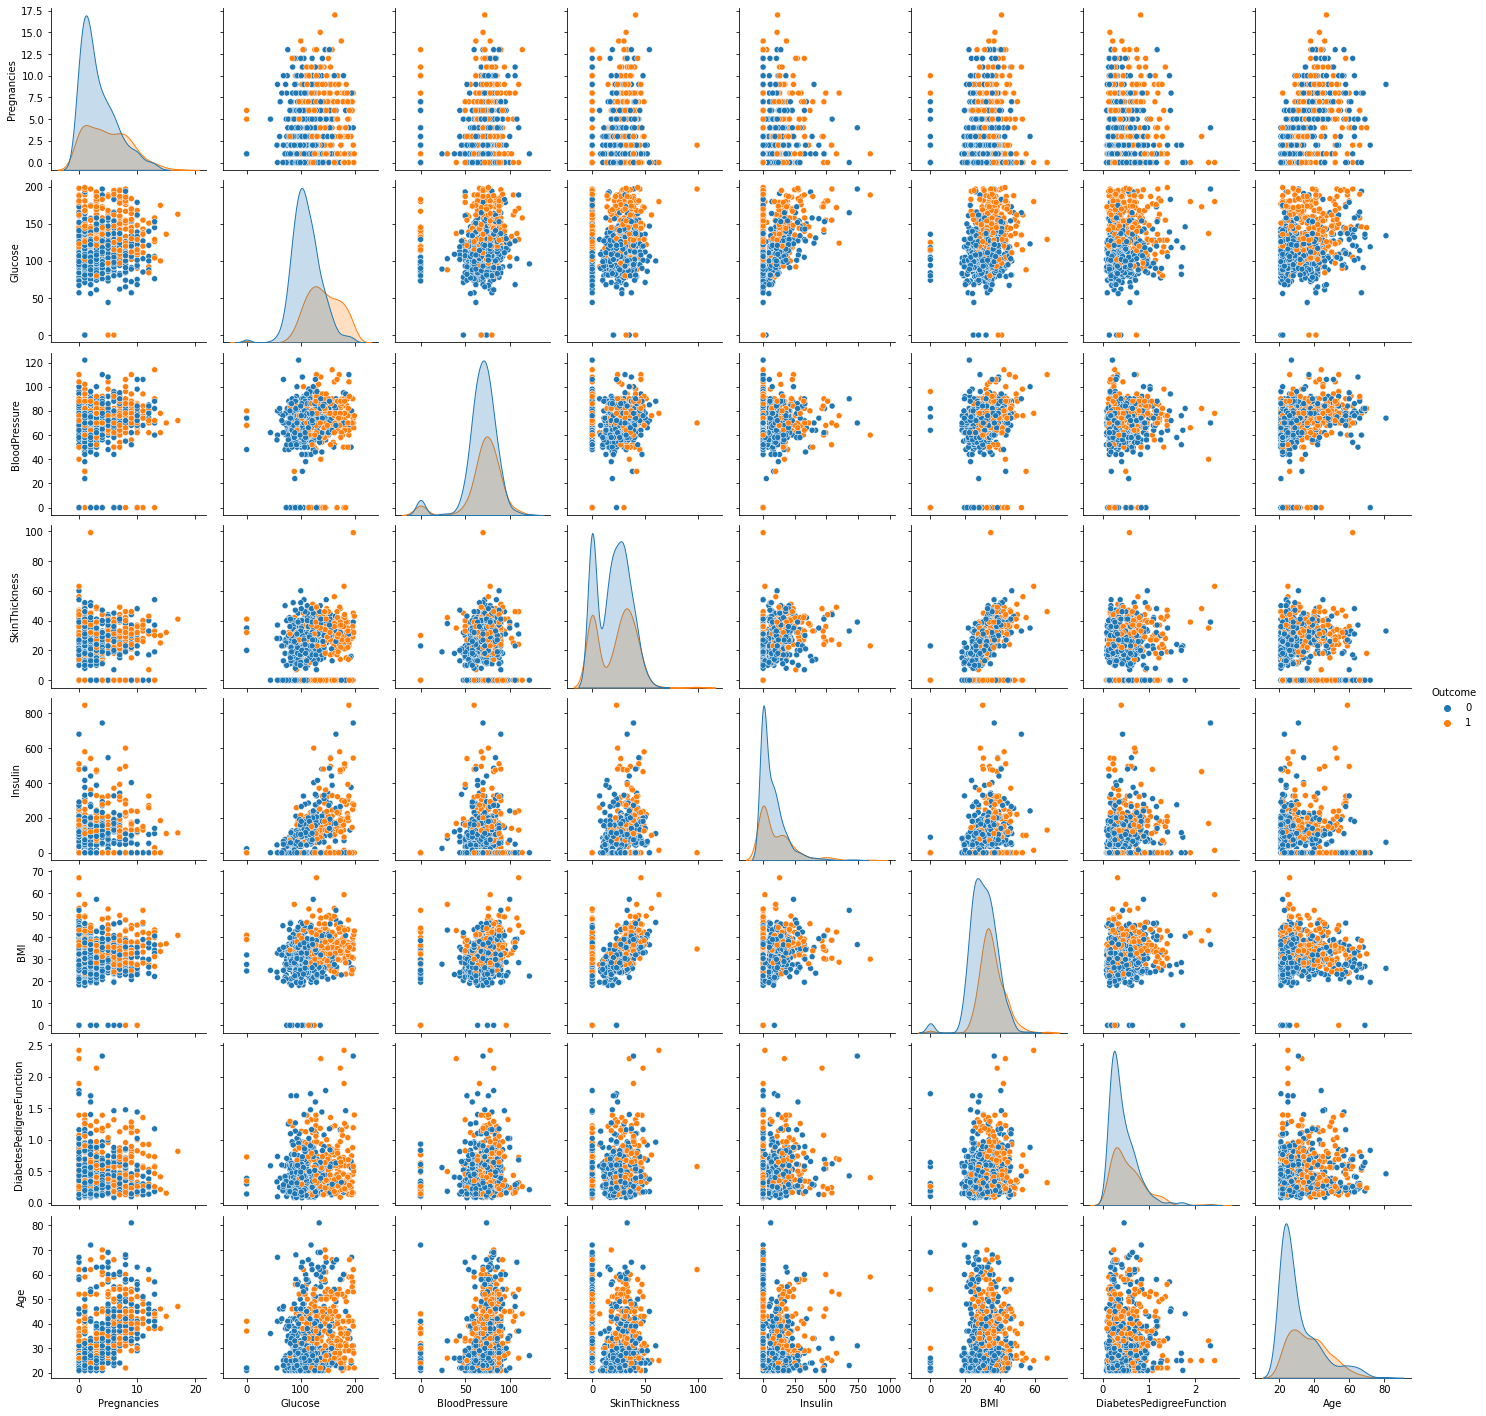

In [ ]:
import seaborn as sns
sns.pairplot(df, hue='Outcome') 

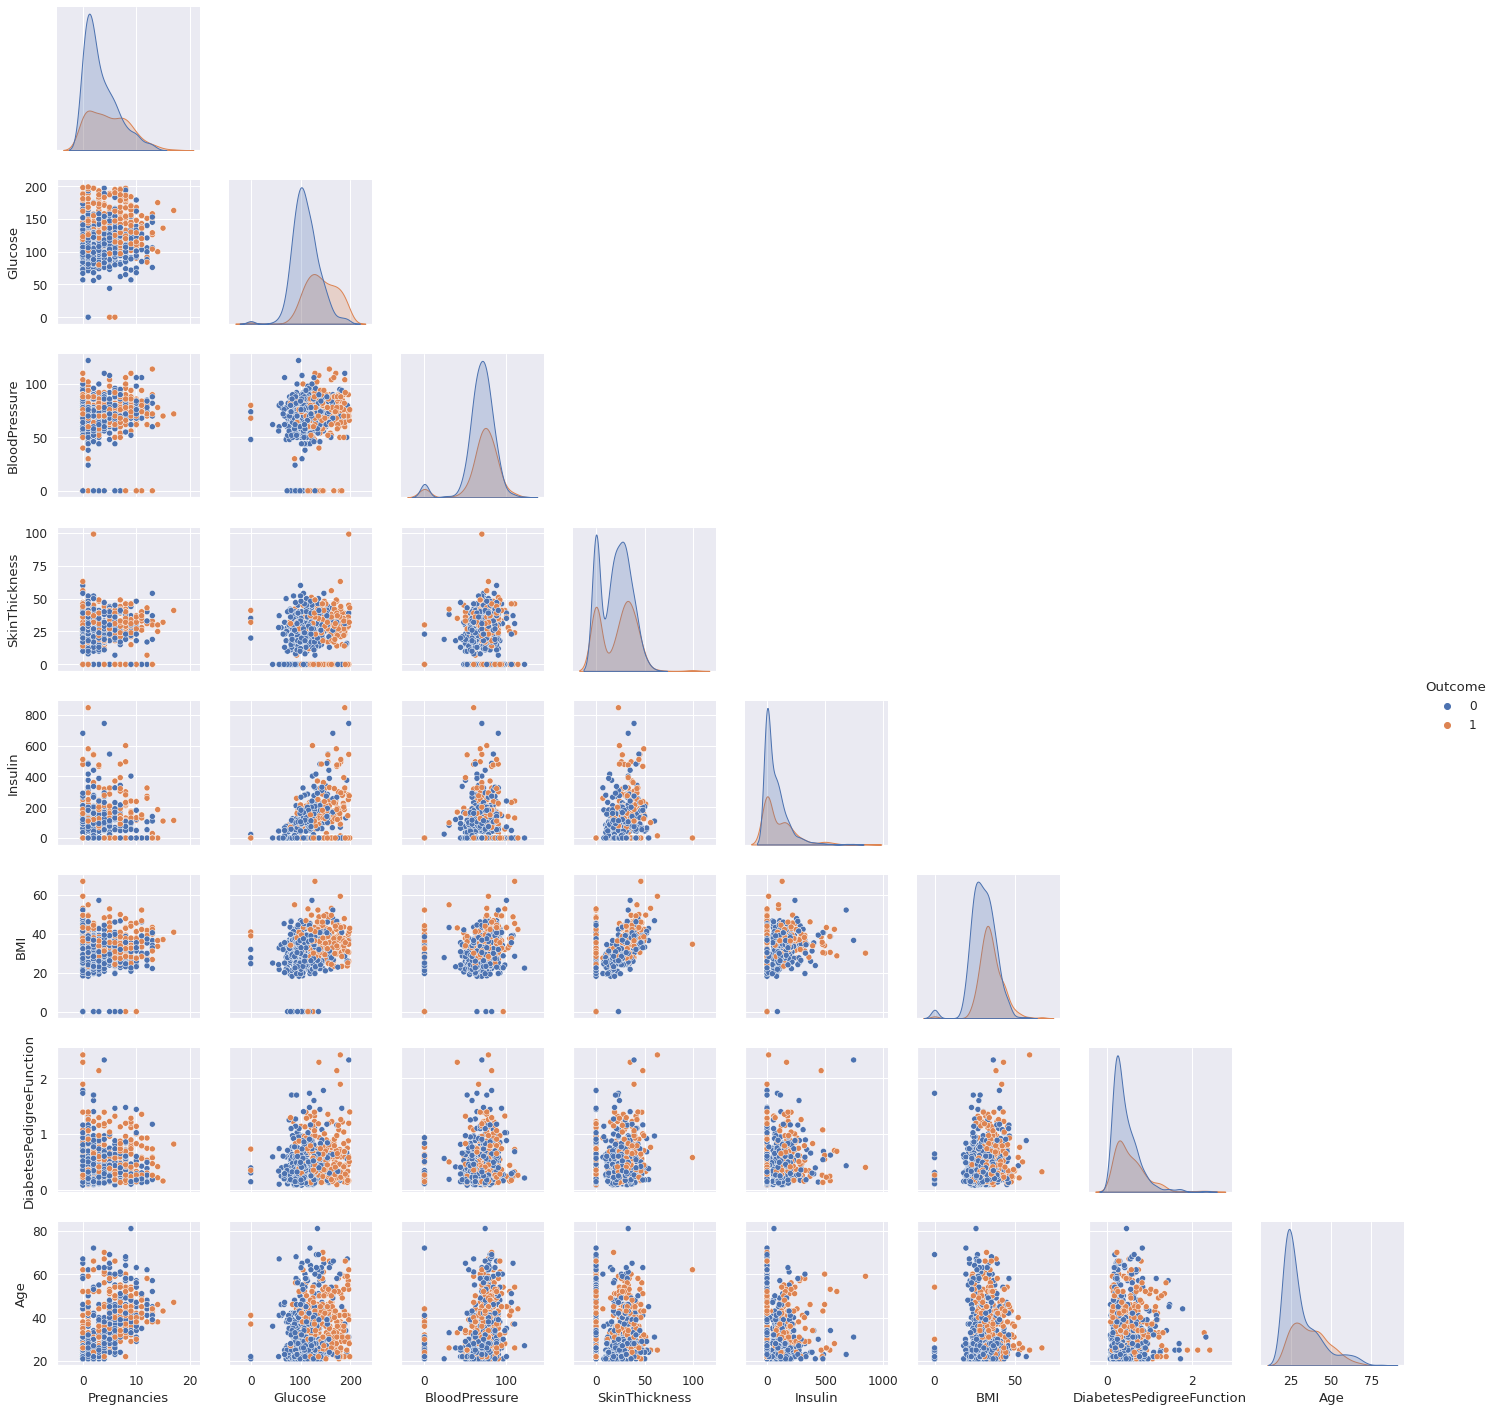

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# defaults
sns.set(font_scale=1.1)

pairplot=sns.pairplot(df, hue='Outcome', corner=True)
pairplot.savefig("pairplot_nocorner.png", dpi=400) 

In [ ]:
df

In [ ]:
a=df['Outcome'].iloc
for k, j in enumerate([i for i in a]):
  if j == 1:
    df['Outcome'].iloc[k]='Diabetic'
  if j==0:
    df['Outcome'].iloc[k]='Healthy'


In [26]:
import plotly.express as px
import plotly.graph_objects as go

b=.06
a=(1-b*3)/4
d=[]
for i in range(4):
  l=i*(b+a)
  o=[l,l+a]
  d.append(o)
dy=[[.0,0.475],[.525, 1]]

fig1=go.Box( y=df['Outcome'], x=df['Age'],boxmean='sd', name='Age', xaxis='x',yaxis="y")
fig2=go.Box( y=df['Outcome'], x=df['BMI'],boxmean='sd', name='BMI', xaxis='x2',yaxis="y2" )
fig3=go.Box( y=df['Outcome'], x=df['Glucose'],boxmean='sd', name='Glucose', xaxis='x3',yaxis="y3" )
fig4=go.Box( y=df['Outcome'], x=df['SkinThickness'],boxmean='sd', name='Skin Thickness', xaxis='x4',yaxis="y4" )
fig5=go.Box( y=df['Outcome'], x=df['BloodPressure'],boxmean='sd', name='Blood Pressure', xaxis='x5',yaxis="y" )
fig6=go.Box( y=df['Outcome'], x=df['Pregnancies'],boxmean='sd', name='Pregnancies', xaxis='x6',yaxis="y2" )
fig7=go.Box( y=df['Outcome'], x=df['Insulin'],boxmean='sd', name='Insulin', xaxis='x7',yaxis="y3" )
fig8=go.Box( y=df['Outcome'], x=df['DiabetesPedigreeFunction'],boxmean='sd', name='Pedigree Function', xaxis='x8',yaxis="y4" )
layout = go.Layout(
    yaxis=dict(domain=d[0]),
    xaxis=dict(anchor='y',domain=dy[0]),
    yaxis2=dict(domain=d[1]),
    xaxis2=dict(anchor='y2',domain=dy[0]),
    yaxis3=dict(domain=d[2]),
    xaxis3=dict(anchor='y3',domain=dy[0]),
    yaxis4=dict(domain=d[3]),
    xaxis4=dict(anchor='y4',domain=dy[0]),
    xaxis5=dict(anchor='y',domain=dy[1]),
    xaxis6=dict(anchor='y2', domain=dy[1]),
    xaxis7=dict(anchor='y3', domain=dy[1]),
    xaxis8=dict(anchor='y4', domain=dy[1]),
    )

data=[fig1,fig2,fig3,fig4,fig5,fig6,fig7,fig8][::-1]
fig = go.Figure(data=data, layout=layout, ).update_traces(orientation='h')
fig.update_layout(autosize=False, width=1700, height=1100,font=dict(size=22))
fig.show()
fig.write_image('T_test.png', scale=4)

In [ ]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79.9 MB 145 kB/s 


In [ ]:
dfa=pd.read_excel('/content/db.xlsx')
dfa['decision']=list((0,)*768)
dfa['dy']=list(np.arange(-.5,1.5,0.0026041666666666665))[:768]
dfa['xsig']=list(np.arange(-7,7,0.01822))[:768]
dfa['ysig']=list(1/(1+np.exp(-np.arange(-7,7,0.01822))))[:768]
dfa.head(2)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig1 = px.line(dfa, x='xsig', y='ysig', title='P(diabetes)')
fig2 = px.line(dfa, x='decision', y='dy')#, name='decision line')
fig3 = px.scatter(dfa,x='z', y='predicted_class', color='Outcome' )
all_fig = go.Figure(data=fig1.data + fig2.data + fig3.data, layout = fig3.layout)

In [ ]:
1/768

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=healty[:,1], y=healty[:,0], opacity=.95,
                    mode='markers', name='healty'))
fig.add_trace(go.Scatter(x=diabetes[:,1], y=diabetes[:,0],opacity=.8,
                    mode='markers', name='diabetic'))
fig.add_trace(go.Scatter(x=dfa['xsig'], y=dfa['ysig'],
                    mode='lines',
                    name='P(diabetes)'))
fig.add_trace(go.Scatter(x=dfa['decision'], y=dfa['dy'],
                    mode='lines',
                    name='Decision line'))

fig.update_layout(autosize=False, width=2000, height=900,font=dict(size=26))
fig.show()
fig.write_image('log_reg.png', scale=4)

In [ ]:
 healty=[]
diabetes=[]
for k,i,j in np.asarray(dfa.iloc[:,[0,2,3]]):
  if k==0:
    healty.append([i,j])
  else:
    diabetes.append([i,j])
healty=np.asarray(healty)
diabetes=np.asarray(diabetes)

In [ ]:
healty